In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torchAA import torchAA
from torchNMF import NMF
from ShiftNMF_half_frequencies import ShiftNMF
from torchShiftAA import torchShiftAA
import torch
from helpers.callbacks import explained_variance

## Data

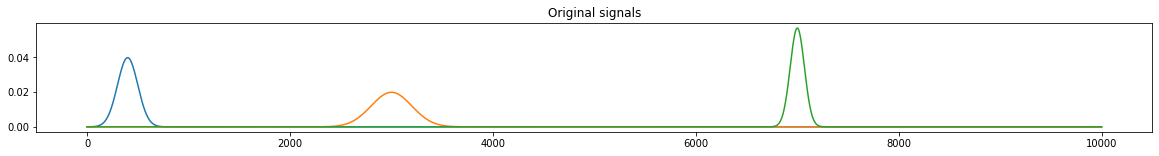

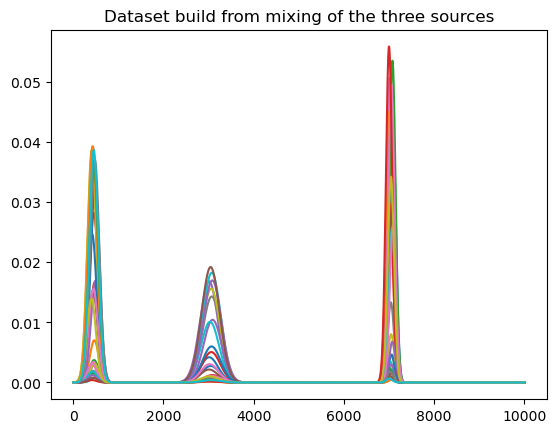

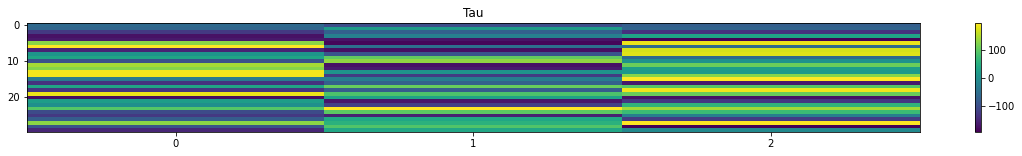

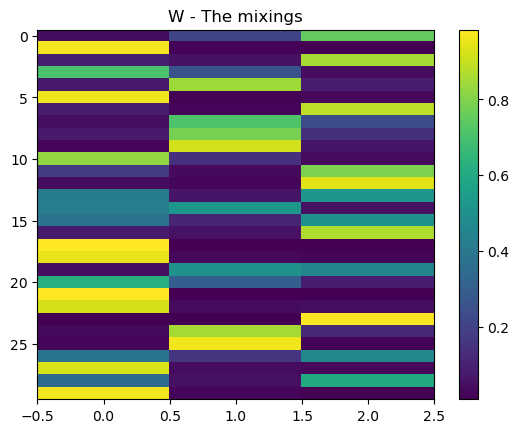

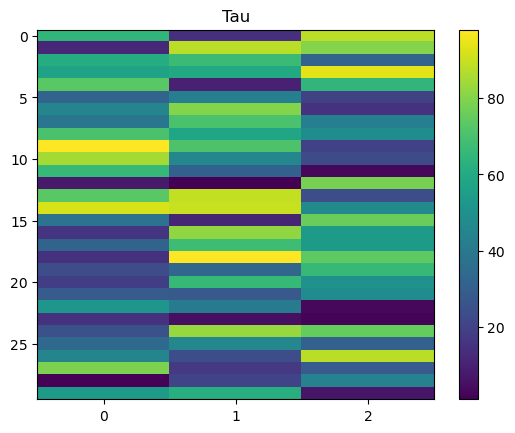

In [3]:
#Create data
# Define random sources, mixings and shifts; H, W and tau
N, M, d = 30, 10000, 3
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

shift = 200

def gauss(mu, s, time):
    return 1/(s*np.sqrt(2*np.pi))*np.exp(-1/2*((time-mu)/s)**2)


def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return np.real(V)

# Random mixings:
W = np.random.rand(N-3, d)
#softmax W
W = W / np.sum(W, axis=1)[:, None]

W = np.vstack((W, np.array([1,0,0])))
W = np.vstack((W, np.array([0,1,0])))
W = np.vstack((W, np.array([0,0,1])))
# Random gaussian shifts
tau = np.random.randint(-shift, shift, size=(N, d))
#tau = np.random.randint(0, 1000, size=(N, d))
# Purely positive underlying signals. I define them as 3 gaussian peaks with random mean and std.
mean = [40, 300, 700]
std = [10, 20, 7]
t = np.arange(0, 1000, 0.1)
H = np.array([gauss(m, s, t) for m, s in list(zip(mean, std))])
plt.figure()
for signal in H:
    plt.plot(signal)
plt.title("Original signals")
plt.show()

X = shift_dataset(W, H, tau)
X_clean = shift_dataset(W, H, np.zeros((N, d)))

plt.figure()
for signal in X:
    plt.plot(signal.real)
plt.title("Dataset build from mixing of the three sources")
plt.show()
plt.figure()
plt.imshow(W, aspect='auto', interpolation="none")
plt.colorbar()
plt.title("W - The mixings")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()

## Regular NMF

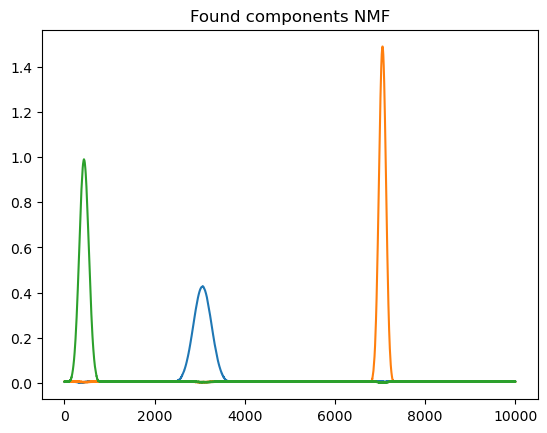

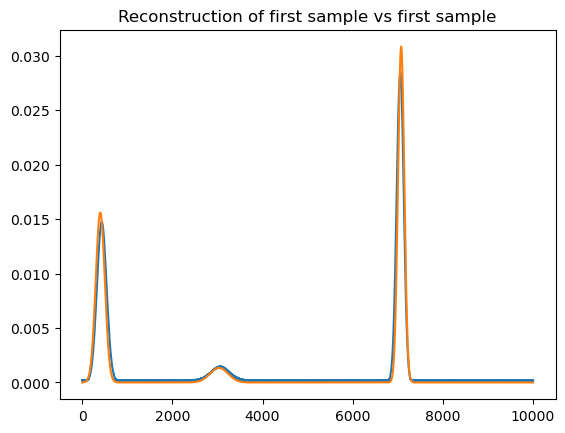

In [7]:

nmf = NMF(X, 3, lr=0.4, factor=0.5)
W, H = nmf.fit(verbose=True)
recon = np.matmul(W, H)

for signal in H:
    plt.plot(signal)
plt.title("Found components NMF")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

## Shift NMF

epoch: 1, Loss: 1256249.481335551
epoch: 2, Loss: 572304.5863295492
epoch: 3, Loss: 261613.34741695662
epoch: 4, Loss: 124013.36655411455
epoch: 5, Loss: 61948.9991643712
epoch: 6, Loss: 32783.014838330775
epoch: 7, Loss: 18352.937623856367
epoch: 8, Loss: 10823.766349219946
epoch: 9, Loss: 6696.006780275838
epoch: 10, Loss: 4327.3650493025
epoch: 11, Loss: 2909.670514073553
epoch: 12, Loss: 2027.691215624285
epoch: 13, Loss: 1459.3834915932207
epoch: 14, Loss: 1081.4046121792264
epoch: 15, Loss: 822.7320756984113
epoch: 16, Loss: 641.0861337075564
epoch: 17, Loss: 510.5211079085946
epoch: 18, Loss: 414.6684571981738
epoch: 19, Loss: 342.93710966091476
epoch: 20, Loss: 288.3137188043091
epoch: 21, Loss: 246.05388786625477
epoch: 22, Loss: 212.88452558232515


KeyboardInterrupt: 

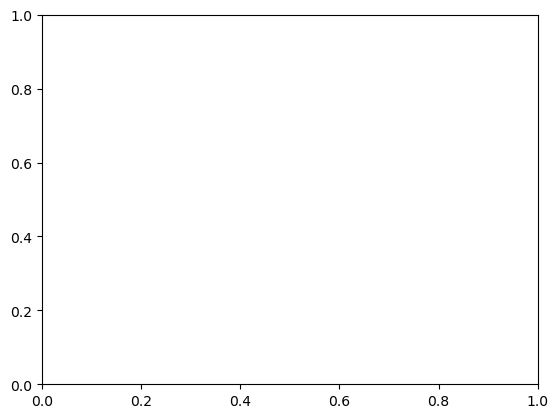

In [8]:

nmf = ShiftNMF(X, 3, lr=0.4, factor=0.5)
W, H, tau = nmf.fit(verbose=True)
recon = nmf.recon.detach().numpy()

for signal in H:
    plt.plot(signal)
plt.title("Found components shift NMF")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


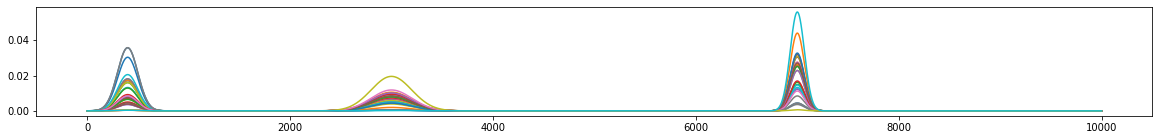

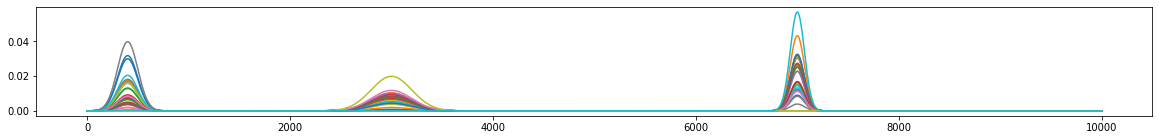

In [ ]:
plt.rcParams['figure.figsize'] = [20, 2]
plt.plot(recon.T)
plt.show()
plt.plot(X_clean.T)
plt.show()

## Regular AA

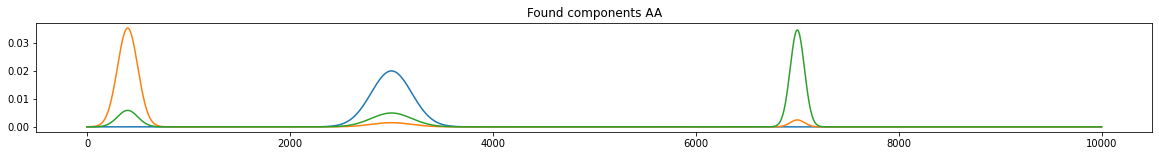

In [213]:
AA = torchAA(X_clean, 3, patience = 10, alpha=1e-5, lr=0.3)
# AA.C = C_init
# AA.S = S_init
C, S = AA.fit(verbose=True)
CX = np.matmul(C, X_clean)
recon_reg = np.matmul(S, CX)

C_init = AA.C
S_init = AA.S


plt.rcParams['figure.figsize'] = [20, 2]
for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()



# plt.plot(recon[1])
# plt.plot(X[1])
# plt.title("Reconstruction of first sample vs first sample (AA)")
# plt.show()

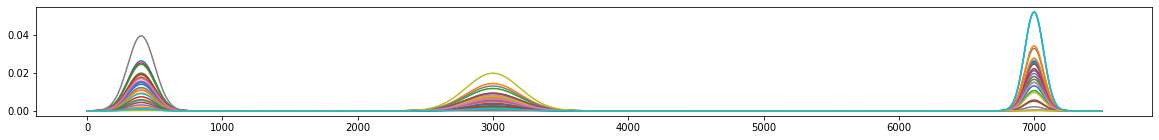

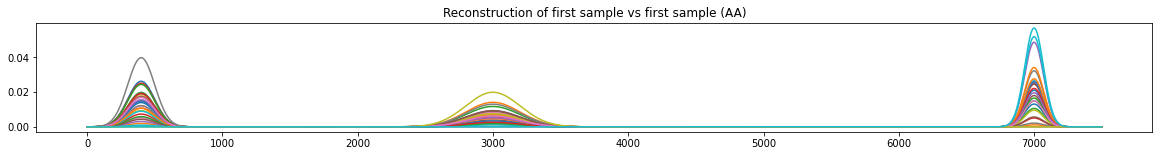

In [198]:
plt.plot(recon_reg.T[:7500])
plt.show()
plt.plot(X_clean.T[:7500])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

## Shift AA

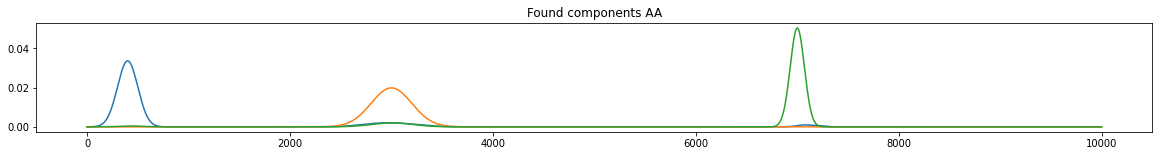

In [8]:
AA = torchShiftAA(X, 3, lr=0.3, patience=10, alpha=1e-5, factor=0.9)
# AA.C_tilde = C_init
# AA.C_tilde = torch.nn.Parameter(AA.C_tilde, requires_grad=True)

# AA.S_tilde = S_init
# AA.S_tilde = torch.nn.Parameter(AA.S_tilde, requires_grad=True)

AA.tau_tilde = torch.nn.Parameter(torch.tensor(tau, dtype=torch.float32), requires_grad=True)

C, S, _ = AA.fit(verbose=True)

recon = AA.recon.detach().resolve_conj().numpy()
A = torch.fft.ifft(AA.A_F).detach().numpy()

CX = A
SCX = recon

recon_no_shift = np.matmul(S,A)

for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()

# plt.plot(recon.T)
# plt.plot(X.T)
# plt.title("Reconstruction of first sample vs first sample (AA)")
# plt.show()



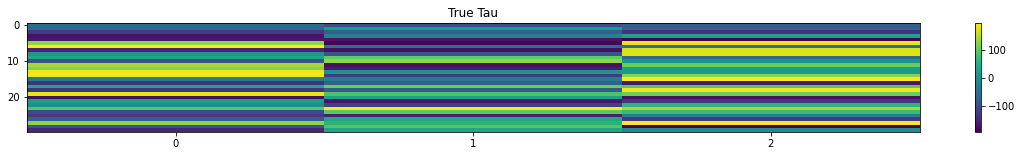

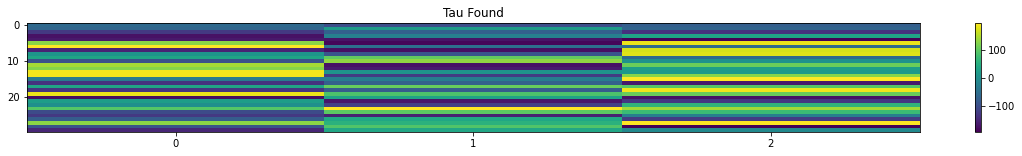

In [220]:
plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("True Tau")
plt.show()

plt.figure()
plt.imshow(_, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau Found")
plt.show()

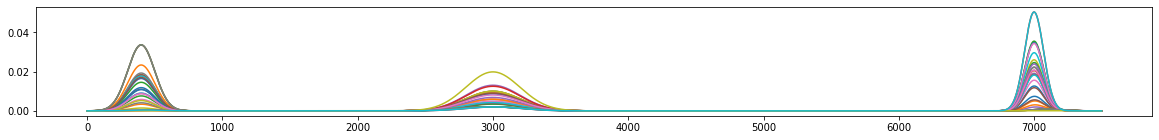

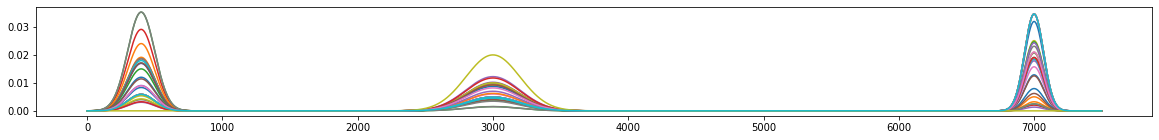

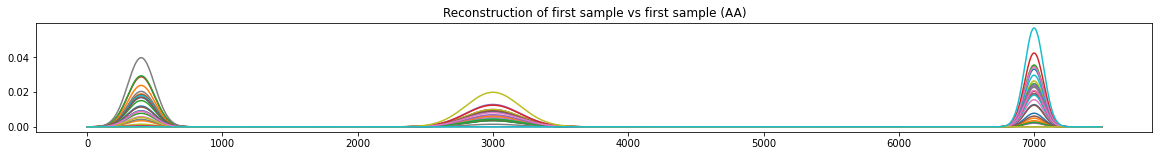

In [221]:
#change figure size
lim = 7500

plt.plot(recon_no_shift.T[:lim])
plt.show()
plt.plot(recon_reg.T[:lim])
plt.show()
plt.plot(X_clean.T[:lim])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

In [ ]:
# tau = AA.fit(verbose=True)

# recon = AA.recon.detach().resolve_conj().numpy()
# A = torch.fft.ifft(AA.A_F).detach().numpy()

# CX = A
# SCX = recon

# for signal in CX:
#     plt.plot(signal)
# plt.title("Found components AA")
# plt.show()

# # plt.plot(recon.T)
# # plt.plot(X.T)
# # plt.title("Reconstruction of first sample vs first sample (AA)")
# # plt.show()



In [ ]:
def expl_var(rec, original):
    return 1-(np.linalg.norm(original - rec, ord="fro")**2 / np.linalg.norm(original - np.mean(original), ord="fro")**2)

In [ ]:
print("Explained variance AA reg: ", expl_var(recon_reg, X_clean))
print("Explained variance AA: ", expl_var(recon, X_clean))

Explained variance AA reg:  1.0
Explained variance AA:  0.721666933107004


In [ ]:
print(explained_variance(recon_reg, X_clean))
print(np.real(explained_variance(recon, X_clean)))

1.0
0.6410087052129281


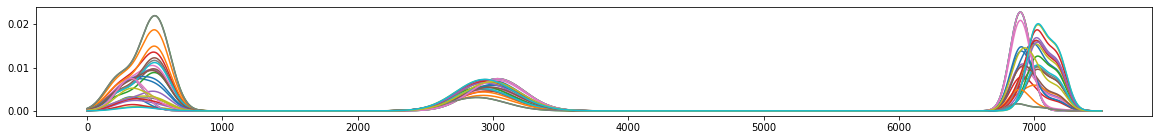

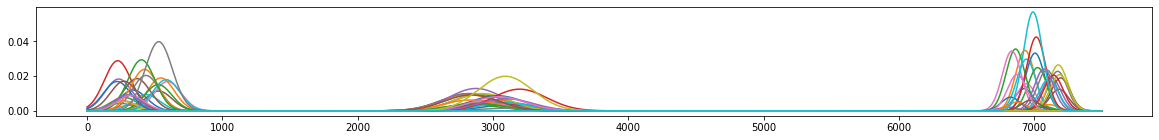

Explained variance AA shift:  0.5898671558274242


In [217]:
recon_shift = AA.recon.detach().numpy()
plt.plot(recon_shift.T[:lim])
plt.show()
plt.plot(X.T[:lim])
plt.show()
print("Explained variance AA shift: ", expl_var(recon_shift, X_clean))